In [1]:
 #===================================================== Import libraries ================================================================================

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn 
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# ================================================= Flexible Layer ================================================================================

    
class FlexiLayer(nn.Module): # class FlexiLayer(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0):
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        super(FlexiLayer, self).__init__()
        
        self.t_1 = nn.Conv2d(self.in_channels, self.out_channels, self.kernel_size, self.stride, self.padding)
        self.t_2 = nn.MaxPool2d(self.kernel_size, self.stride, self.padding) # get max result with the same kernel size
        self.m = nn.Sigmoid()
        
        self.threshold1 = Variable(torch.randn((1, self.out_channels, 30, 30)))
        
        self.thresh_mean = []
        
    def forward(self, t):
        
        #self.threshold1.expand(t.size(0), self.out_channels, 30, 30)
        
        
        #cond = torch.sub(self.t_2(t), self.threshold1.cuda())
        #t_2_2 = self.m(cond*50)*self.t_2(t) # 
        #t_1_1 = self.m(cond*(-50))*self.t_1(t) # 
        #t = torch.add(t_2_2, t_1_1)
        
        return self.t_1(t)

    # ================================================= VGG-16 Network ================================================================================
class VGG16(nn.Module):
    def __init__(self):
        super(VGG16,self).__init__()

        self.block1 = nn.Sequential(
                      nn.Conv2d(in_channels = 3,out_channels = 64,kernel_size = 3,padding = 1),
                      nn.BatchNorm2d(64),
                      nn.ReLU(),
                      FlexiLayer(in_channels = 64,out_channels = 64,kernel_size = 3, padding =0),
                      nn.BatchNorm2d(64),
                      nn.ReLU(),
                      #nn.MaxPool2d(kernel_size=2, stride=2),
                      nn.Dropout2d(0.3))

        self.block2 = nn.Sequential(
                      nn.Conv2d(in_channels = 64,out_channels = 128,kernel_size = 3,padding = 1),
                      nn.BatchNorm2d(128),
                      nn.ReLU(),
                      nn.Conv2d(in_channels = 128,out_channels = 128,kernel_size = 3, padding =1),
                      nn.BatchNorm2d(128),
                      nn.ReLU(),
                      nn.MaxPool2d(kernel_size=2, stride=2),
                      nn.Dropout2d(0.4))

        self.block3 = nn.Sequential(
                      nn.Conv2d(in_channels = 128,out_channels = 256,kernel_size = 3,padding = 1),
                      nn.BatchNorm2d(256),
                      nn.ReLU(),
                      nn.Conv2d(in_channels = 256,out_channels = 256,kernel_size = 3,padding = 1),
                      nn.BatchNorm2d(256),
                      nn.ReLU(),
                      nn.Conv2d(in_channels = 256,out_channels = 256,kernel_size = 3, padding =1),
                      nn.BatchNorm2d(256),
                      nn.ReLU(),
                      nn.MaxPool2d(kernel_size=2, stride=2),
                      nn.Dropout2d(0.4))

        self.block4 = nn.Sequential(
                      nn.Conv2d(in_channels = 256,out_channels = 512,kernel_size = 3,padding = 1),
                      nn.BatchNorm2d(512),
                      nn.ReLU(),
                      nn.Conv2d(in_channels = 512,out_channels = 512,kernel_size = 3,padding = 1),
                      nn.BatchNorm2d(512),
                      nn.ReLU(),
                      nn.Conv2d(in_channels = 512,out_channels = 512,kernel_size = 3, padding =1),
                      nn.BatchNorm2d(512),
                      nn.ReLU(),
                      nn.MaxPool2d(kernel_size=2, stride=2) ,
                      nn.Dropout2d(0.4))

        self.block5 = nn.Sequential(
                      nn.Conv2d(in_channels = 512,out_channels = 512,kernel_size = 3,padding = 1),
                      nn.BatchNorm2d(512),
                      nn.ReLU(),
                      nn.Conv2d(in_channels = 512,out_channels = 512,kernel_size = 3,padding = 1),
                      nn.BatchNorm2d(512),
                      nn.ReLU(),
                      nn.Conv2d(in_channels = 512,out_channels = 512,kernel_size = 3, padding =1),
                      nn.BatchNorm2d(512),
                      nn.ReLU(),
                      nn.MaxPool2d(kernel_size=2, stride=2),
                      nn.Dropout2d(0.5) )

        self.fc =     nn.Sequential(
                      nn.Linear(512,100),
                      nn.Dropout(0.5),
                      nn.BatchNorm1d(100),
                      nn.ReLU(),
                      nn.Dropout(0.5),
                      nn.Linear(100,10), )




    def forward(self,x):
        out = self.block1(x)
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = out.view(out.size(0),-1)
        out = self.fc(out)

        return out


In [2]:
 #===================================================== Import libraries ================================================================================

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn 
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

#from models.VGG16_with_flex_v5 import *


# =================================================== Prepare the dataset ===============================================================================

mean_cifar10 = [0.485, 0.456, 0.406]  # Mean and Std value hase been taken from a github implmentation online.
std_cifar10 = [0.229, 0.224, 0.225]
batch_size = 100
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean_cifar10,std_cifar10),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean_cifar10,std_cifar10),
])

trainset = torchvision.datasets.CIFAR10(root='../FlexibleCNNs/data', train=True, download= True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='../FlexibleCNNs/data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck') # 10 Classes of the cifar-10

# ========================================== Visualising the dataset ==========================================================================
std= torch.FloatTensor(std_cifar10)
mean = torch.FloatTensor(mean_cifar10)
mean = mean[:,None,None]
std = std[:,None,None]
def imshow(img):
    print(img.size())
    img = img*std + mean     # unnormalize
    
    npimg = img.numpy()
    
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

Files already downloaded and verified
Files already downloaded and verified
torch.Size([3, 36, 138])
 frog plane  deer truck


In [3]:
# =============================================================== Model initialisation, Loss function and Optimizer =====================================
model = VGG16()
if torch.cuda.is_available():
    model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr = 0.001,momentum = 0.9,weight_decay = 0.006)
schedule = torch.optim.lr_scheduler.StepLR(optimizer,step_size=20,gamma = 0.7)

total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} trainable parameters.')

14,775,646 total parameters.
14,775,646 trainable parameters.


Epoch:  0   Loss:  1072.9314388036728   Train Accuracy : 17.348


Test accuracy: 12 %
Epoch:  1   Loss:  966.2481273412704   Train Accuracy : 24.836


Test accuracy: 19 %
Epoch:  2   Loss:  900.1126886606216   Train Accuracy : 30.928


Test accuracy: 32 %
Epoch:  3   Loss:  849.4689872264862   Train Accuracy : 35.796


Test accuracy: 37 %
Epoch:  4   Loss:  811.4248811006546   Train Accuracy : 39.77


Test accuracy: 45 %
Epoch:  5   Loss:  777.7746087312698   Train Accuracy : 43.396


Test accuracy: 47 %
Epoch:  6   Loss:  742.4806206226349   Train Accuracy : 46.906


Test accuracy: 54 %
Epoch:  7   Loss:  706.1950933933258   Train Accuracy : 50.562


Test accuracy: 54 %
Epoch:  8   Loss:  670.9036021232605   Train Accuracy : 53.956


Test accuracy: 59 %
Epoch:  9   Loss:  632.5935108065605   Train Accuracy : 57.152


Test accuracy: 62 %
Epoch:  10   Loss:  597.9664852619171   Train Accuracy : 60.02


Test accuracy: 64 %
Epoch:  11   Loss:  570.8041721582413   Train Accuracy : 62.424



Test accuracy: 90 %
Epoch:  96   Loss:  91.82508584856987   Train Accuracy : 97.016


Test accuracy: 90 %
Epoch:  97   Loss:  92.52032153308392   Train Accuracy : 96.986


Test accuracy: 90 %
Epoch:  98   Loss:  88.97878257930279   Train Accuracy : 97.192


Test accuracy: 90 %
Epoch:  99   Loss:  89.1656788289547   Train Accuracy : 97.114


Test accuracy: 90 %
Epoch:  100   Loss:  82.2398584857583   Train Accuracy : 97.5


Test accuracy: 90 %
Epoch:  101   Loss:  78.07814829051495   Train Accuracy : 97.896


Test accuracy: 91 %
Epoch:  102   Loss:  76.45406240224838   Train Accuracy : 97.994


Test accuracy: 90 %
Epoch:  103   Loss:  75.24915624409914   Train Accuracy : 98.006


Test accuracy: 91 %
Epoch:  104   Loss:  74.6754747480154   Train Accuracy : 98.062


Test accuracy: 90 %
Epoch:  105   Loss:  74.05298670381308   Train Accuracy : 98.096


Test accuracy: 91 %
Epoch:  106   Loss:  74.7734477892518   Train Accuracy : 98.046


Test accuracy: 90 %
Epoch:  107   Loss:  73.556432574

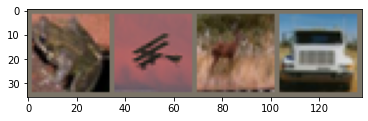

In [4]:
# ======================== Function to get the test accuracy ===============================================================================
def test():
    correct = 0
    total = 0
    model.train(False)
    with torch.no_grad():
        for i,(images,labels)in enumerate(testloader):
            if torch.cuda.is_available():
                images = images.cuda()
                labels = labels.cuda()
            outputs = model(Variable(images))
            labels = Variable(labels)
            _,predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted.eq(labels)).sum().item()
        print('Test accuracy: %d %%' % (
        100 * correct / total))
    return 100*(correct/total)

#======================================================= Training =========================================================================
num_epochs = 152  # Train for 150 epochs
start_epoch = 0

total_step = len(trainloader)
train_loss = []  # Store the train_loss per epoch
test_accuracy = [] # Store the test_accuracy per epoch
train_error = []
for epoch in range(start_epoch,num_epochs+1):
    model.train(True)
    epoch_loss  = 0
    i_count = 0
    acc_total = 0
    for i,(images,labels) in enumerate(trainloader):
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
        labels = Variable(labels)
        optimizer.zero_grad()
        outputs = model(Variable(images))
        loss = criterion(outputs,labels)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
        _,predicted = outputs.max(1)
        denom = labels.size(0)
        correct = predicted.eq(labels).sum().item()
        acc = 100*(correct/denom)
        acc_total += acc
        i_count = i_count + 1

    #if(i%20 == 0):  # Print the loss per 20 iterations
      #print("Epoch: ",epoch," ","Iteration: ",i," loss: ",loss.item()," Train_iter Accuracy: ",acc)
    schedule.step()
    train_loss.append(epoch_loss)
    print("Epoch: ",epoch," ","Loss: ",epoch_loss," ","Train Accuracy :",acc_total/i_count) # Print train accuracy per epoch
    print('\n')
    test_acc = test()      # Print the test accuracy per epoch
    test_accuracy.append(test_acc)
    train_error.append(100 - acc_total/i_count)
    
    #Save every epoch
    state = {
        'model': model.state_dict(),
        'acc' : test_acc,
        'optim':optimizer.state_dict(),
        'epoch' : epoch
    }
    path = './models2/VGG16-BASE-nnmodule_withdropout' + 'model_' + str(int(epoch)) +'_' + str(int(test_acc))+'.pth'
    torch.save(state,path)


In [10]:
#save test accuracy to plot

import pickle

with open('cifar_base_withdropout_testaccuracy2.pkl', 'wb') as f:
    pickle.dump(test_accuracy, f)


with open('cifar_base_withdropout_trainerror2.pkl', 'wb') as f:
    pickle.dump(train_error, f)

In [2]:
import pickle 

with open('cifar_base_withdropout_testaccuracy2.pkl', 'rb') as f:
    test_accuracy = pickle.load(f)
    
for i in range(152):
    print(i)
    print(test_accuracy[i])

0
17.83
1
23.45
2
32.910000000000004
3
40.089999999999996
4
42.61
5
48.089999999999996
6
50.849999999999994
7
56.279999999999994
8
61.39
9
64.31
10
65.28
11
68.56
12
68.61
13
72.24000000000001
14
73.09
15
73.33
16
77.39
17
77.83
18
79.7
19
80.19
20
81.61
21
82.12
22
82.53
23
82.54
24
83.6
25
82.56
26
84.1
27
84.55
28
85.18
29
84.99
30
85.36
31
85.52
32
86.50999999999999
33
85.78
34
85.91
35
86.89
36
86.94
37
87.38
38
87.14
39
87.49
40
88.26
41
87.5
42
88.48
43
88.18
44
87.77000000000001
45
88.66000000000001
46
88.62
47
88.41
48
88.64
49
88.75
50
88.86
51
89.03999999999999
52
88.79
53
88.9
54
89.23
55
88.9
56
87.49
57
89.12
58
88.62
59
88.44
60
89.64
61
89.62
62
89.82
63
90.10000000000001
64
89.7
65
89.55
66
89.79
67
89.56
68
89.63
69
89.47
70
89.78
71
89.48
72
89.45
73
89.75999999999999
74
90.24
75
90.18
76
89.97
77
90.03
78
90.32
79
90.10000000000001
80
90.64
81
90.73
82
90.47
83
90.51
84
90.64
85
90.48
86
90.58
87
90.32
88
90.81
89
89.99000000000001
90
90.58
91
90.55
92
90.61
93
90.5